In [3]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')

import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, distortion_report,
    resolution_bars_report, uniformity_report, snr_report
)

from mriqa.xmlqa.coilqa import (
    find_qa_results_file,
    coil_snr, coil_snr_history, coil_name, coil_names,
    plot_coil_images, 
    MINCOILSERNO
)

from dcmextras.siemenscsa import csa

# Percent above specification
MARGIN = 5 
margin_colour = lambda x: 'color: %s' % ('green' if x>= MARGIN else 'orange' if x>0 else 'red')
ok_colour     = lambda x: 'color: %s' % ('green' if x else 'red')

from datetime import datetime

import fmriqa

# MRI Physics QA -  CRIC Skyra
- Tests Performed:
  - Slice shape and Profile
  - Distortion and Field of View
  - In Plane Resolution
  - Ghosting
  - Head Coil SNR
  - Head Coil Image Uniformity
  - Long Term Stability
  - SVS Line Width and Shape

All of the above are acceptable.

In [2]:
text = '''
R. Hartley-Davies, J. Delve, S. Curtis, H. Elbert
Medical Physics & Bioengineering, UH Bristol
January 2018
'''
display(HTMLLatex(
    r'<pre>' + text + r'</pre>',
    r'\vfill' + '\n' + r'\begin{verbatim}' + '\n' + text + '\n' + r'\end{verbatim}' + '\n'
))


In [3]:
NewPage

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo with a T<sub>E</sub> of 30ms.

### 3 mm Slice

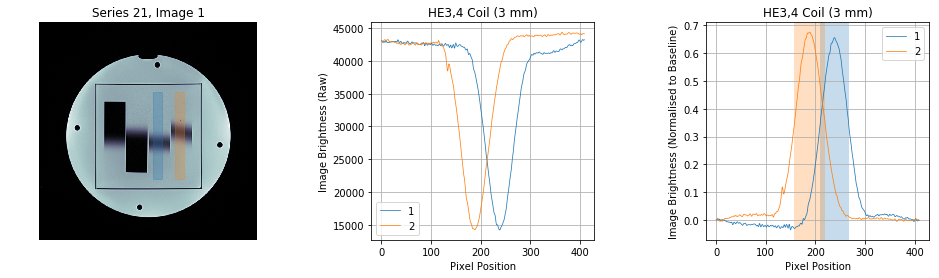

Plate Angle  =  11.7 degrees
FWHM     (1) =  59.2 pixels, or 3.0 mm
FWHM     (2) =  63.0 pixels, or 3.2 mm
FWHM (GMEAN) =  61.0 pixels, or 3.1 mm


In [4]:
# TO2: Slice 3mm
patid = 'PQA20180130RHD'
stuid = '1'

# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[21])
slice_idx = 0
results = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)

### 5 mm Slice

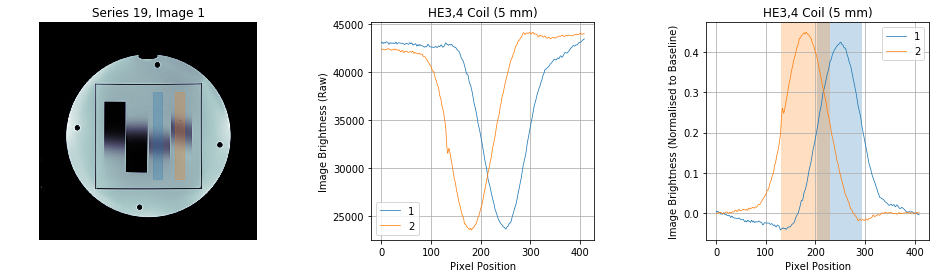

Plate Angle  =  11.7 degrees
FWHM     (1) =  90.5 pixels, or 4.6 mm
FWHM     (2) =  98.1 pixels, or 5.0 mm
FWHM (GMEAN) =  94.2 pixels, or 4.8 mm


In [5]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[19])
slice_idx = 0
result = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [6]:
results[['FWHMGMeanPixels', 'FWHMGMeanMM']]

FWHMGMeanPixels  FWHMGMeanMM
SliceThickness                              
3.0                   61.032939     3.085770
5.0                   94.201584     4.762747

These are both rather rounded profiles as seen on other Siemens scanners with this protocol. The profile widths, though, are well within the AAPM tolerance of 0.5mm.

In [7]:
NewPage

## Image Scaling and Geometric Distortion

The TO2 phantom has a square box for scale and distortion measurements. The scale reflects the Gradient Sensitivity calibration performed by the manufacturer as part of the system installation. These results are after applying Siemens 2D distortion correction.

In [8]:
# TO2: Distortion
# SE: Axial, Phase RL, 512 matrix
dobjs = fetch_series(patid, stuid, sernos=[21])

slice_idx = len(dobjs) // 2
results = distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)

Horizontal Scale / Distortion:    121.1 mm / 0.05 %
Vertical Scale / Distortion:      120.2 mm / 0.08 %


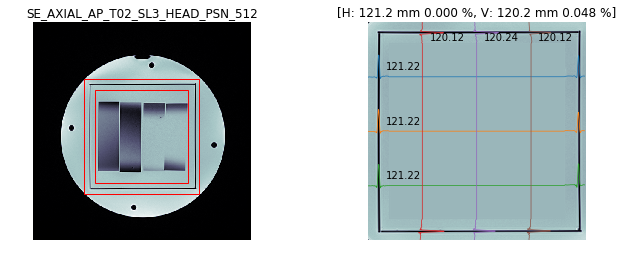

Horizontal Scale / Distortion:    121.2 mm / 0.00 %
Vertical Scale / Distortion:      120.2 mm / 0.05 %


In [9]:
# TO2: Distortion
# SE: Axial, Phase AP, 512 matrix
dobjs = fetch_series(patid, stuid, sernos=[23])

slice_idx = len(dobjs) // 2
results = results.append(distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False))

In [10]:
results[['Orientation', 'PhaseDirection', 'Sensitivity', 'HorizontalScale', 'HorizontalDistortion','VerticalScale', 'VerticalDistortion' ]]

Orientation PhaseDirection  Sensitivity  HorizontalScale  \
Series                                                            
21           Axial             RL     0.236011        121.05306   
23           Axial             AP     0.236011        121.21582   

        HorizontalDistortion  VerticalScale  VerticalDistortion  
Series                                                           
21                  0.047537     120.239258            0.082893  
23                  0.000000     120.157878            0.047891

Distortion (arising from both residual gradient nonlinearity and static field inhomogeneity) is acceptable at the bandwidth used (260Hz/pixel).

In [11]:
NewPage

## Spatial Resolution

The resolution is assessed using the TO4 phantom, which has parallel plates of various separations. These are results for the highest resolution scan (1024x1024).

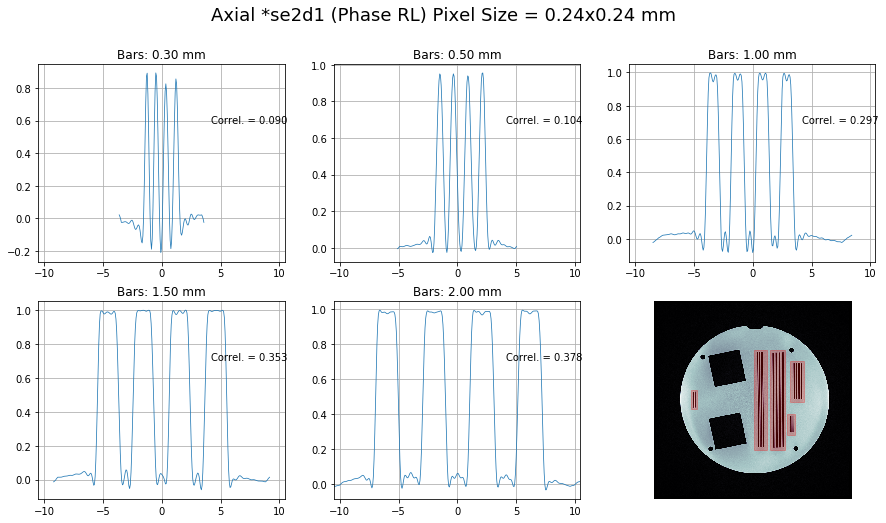

In [12]:
patid = 'PQA20180112CRIC'
stuid = '1'
# TO4: Resolution
dobjs = fetch_series(patid, stuid, sernos=[55])
slice_idx = 0
result = resolution_bars_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=True)

All the bar features are well resolved at this resolution.

In [13]:
NewPage

## Ghosting

Image ghosting is assessed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and four example sequences.

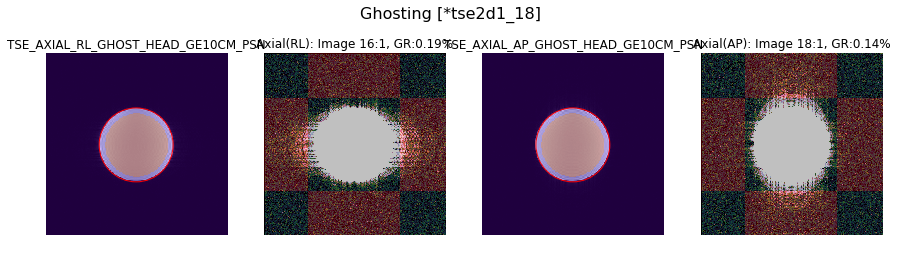

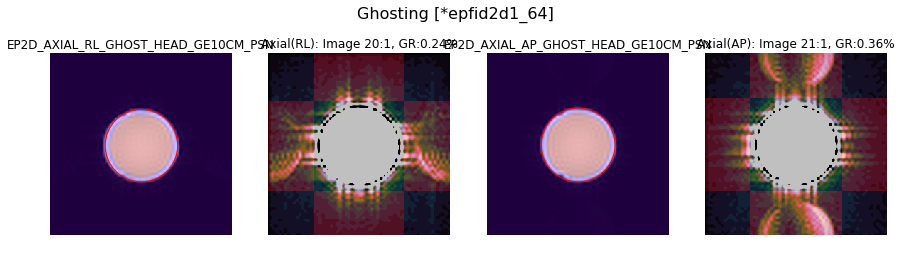

Sequence Orientation PhaseDirection  GhostRatio
Series                                                     
12            *se2d1       Axial             RL    0.015576
14            *se2d1       Axial             AP    0.025369
16        *tse2d1_18       Axial             RL    0.185383
18        *tse2d1_18       Axial             AP    0.140356
20      *epfid2d1_64       Axial             RL    0.236772
21      *epfid2d1_64       Axial             AP    0.360275
22      *epse2d1_128       Axial             RL    0.688801
24      *epse2d1_128       Axial             AP    0.821323

In [14]:
# GE10CM: Ghosting

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [12, 14]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [16, 18]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [20, 21]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [22, 24]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

display(results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']])

The level of ghosting is much less than 1% for all sequences measured here including the EPI.

In [15]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the 32 channel head coil using a spherical phantom filled with a silicone oil. Results are presented both before and after Siemens `prescan-normalize` intensity correction.

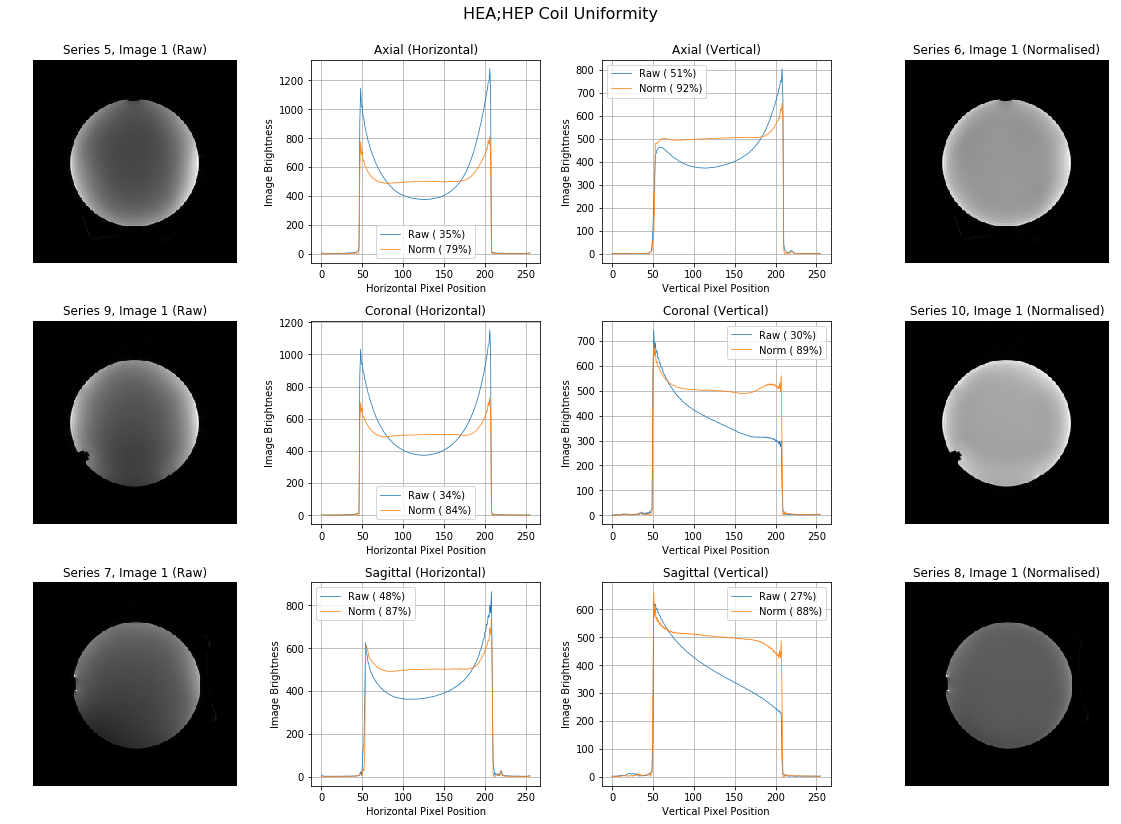

Raw Images


SeriesRaw                        ProtocolRaw    OrientRaw  \
Axial             5  SE_AXIAL_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal           9    SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/HF   
Sagittal          7    SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

          XUniformityRaw  YUniformityRaw  
Axial          35.403727       50.625000  
Coronal        33.540373       29.559748  
Sagittal       47.798742       26.582278

Intensity Normalised Images


SeriesNorm                       ProtocolNorm   OrientNorm  \
Axial              6  SE_AXIAL_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal           10    SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/HF   
Sagittal           8    SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

          XUniformityNorm  YUniformityNorm  
Axial           78.881988        92.405063  
Coronal         84.472050        89.308176  
Sagittal        87.179487        88.050314

In [16]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
raw_tra = fetch_series(patid, stuid, sernos=[5])
psn_tra = fetch_series(patid, stuid, sernos=[6])
raw_sag = fetch_series(patid, stuid, sernos=[7])
psn_sag = fetch_series(patid, stuid, sernos=[8])
raw_cor = fetch_series(patid, stuid, sernos=[9])
psn_cor = fetch_series(patid, stuid, sernos=[10])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

print('Raw Images')
display(results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']])
print('Intensity Normalised Images')
display(results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']])

As expected for a multi-element coil the uncorrected images are highly non-uniform. However, the Siemens `prescan-normalize` intensity correction is adequate in compensating for this though there is some residual surface brightening in the horizontal direction on all three axes as indicated by the slightly lower values for the horizonal uniformity.

In [17]:
NewPage

## Signal to Noise

The Siemens QA involves a comprehensive element by element assessment of the SNR of all the coils. For reference purposes the following is an independent estimate for the head coil using the Siemens long bottle phantom. The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from a region within the phantom in the mean of two images and the noise is estimated from a background region in their difference image.

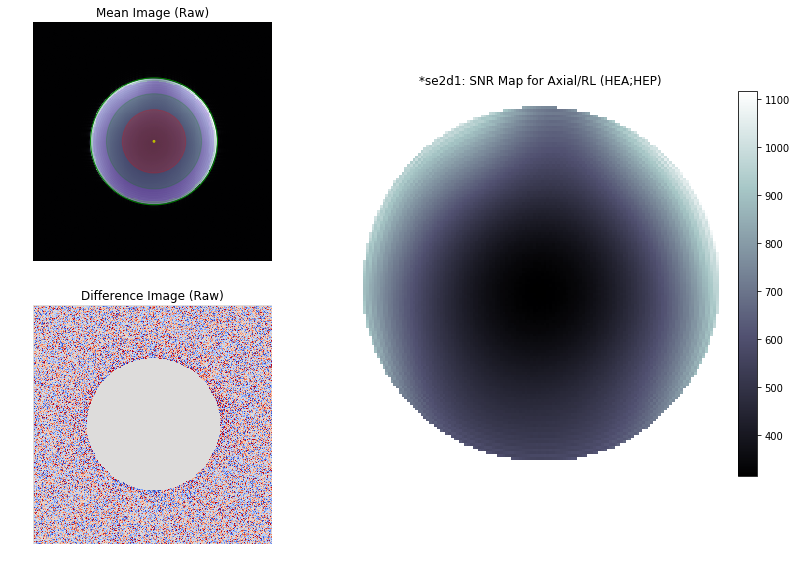

SNR: Raw Images


HEA;HEP
0.50    399.0
0.75    490.0

In [18]:
# LONGBOTTLE: Signal to Noise
raw_tra = fetch_series(patid, stuid, sernos=[28, 31])
if len(raw_tra) > 1:
    results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]])
else:
    results = snr_report(raw_dobjs=[raw_tra[0]])
plt.show()

print('SNR: Raw Images')
display(np.round(results))

In [19]:
NewPage

## Long Term Stability
We assessed the long term stability of an EPI acquisition over a period of 20 minutes. This was performed on a spherical silicone oil phantom using the bold (mosaic) EPI sequence.

In [20]:
# CRIC Skyra January 2018
specified_date = '20180103'
patid = 'FMRIQA20180103RHD'
stuid = '1'
series_description = 'ep2d_fbirn_20min'

# Interface to query DICOM server for images
import dicom as dcm
from dcmfetch.queryinterface import QueryInterface, QIError
from dcmfetch.aettable import AetTable

import os
import platform

# Details of CRIC's DICOM Server
DFLT_LOCAL_AET = platform.node().split('.')[0] + 'Store'
qi = QueryInterface(AetTable(), DFLT_LOCAL_AET)
server = 'Dcm4Chee'

# Get the protocol from the FMRIQA study
from operator import attrgetter
matching_patients = sorted(qi.pat_level_find(server, '*', patid, '*', '*'), key=attrgetter('patid'))

seriess = []
for patid in [pat.patid for pat in matching_patients]:
    seriess += qi.combo_find(server, patid)

# Most recent scans
seriess.sort(key=lambda s: s.studydate)
if specified_date:
    try:
        index = [s.studydate.strip() for s in seriess].index(specified_date.strip())
        studydate = seriess[index].studydate
    except ValueError as e:
        raise ValueError('Date %s not found (%s) - nb: format should be YYYYmmdd' % (specified_date, e))
else:
    studydate = seriess[-1].studydate
series = list(filter(lambda s: s.studydate == studydate and s.description == series_description, seriess))[0]

# Fetch series from server to a temporary directory and read from there
from tempfile import mkdtemp
from shutil import rmtree
tempdir = mkdtemp()

# NB Returns a generator hence list() to force iteration
list(qi.series_level_fetch(server,
                      patid=series.patid, studyuid=series.studyuid, seriesuid=series.seriesuid,
                      savedir=tempdir))

time_series, (dx, dy, dz, dt) = fmriqa.read_mosaic_time_series(tempdir, ['*'])
dicom_series = fmriqa.read_dicom_objs_time_sorted(tempdir, ['*'])

rmtree(tempdir)
nt, nz, ny, nx = time_series.shape
assert nx>0 and ny>0 and nz>0 and nt>0
assert dx>0 and dy>0 and dz>0 and dt>0

tstart = 2 + nt%2
zmiddle = nz//2
central_slice_time_series = time_series[tstart:, zmiddle, :, :]
HTMLLatex(
    '<h3>fBIRN QA Results for %s</h3>'
     % dicom_series[0].StationName,
    r'\subsubsection{fBIRN QA Results for %s}'
     % dicom_series[0].StationName
)

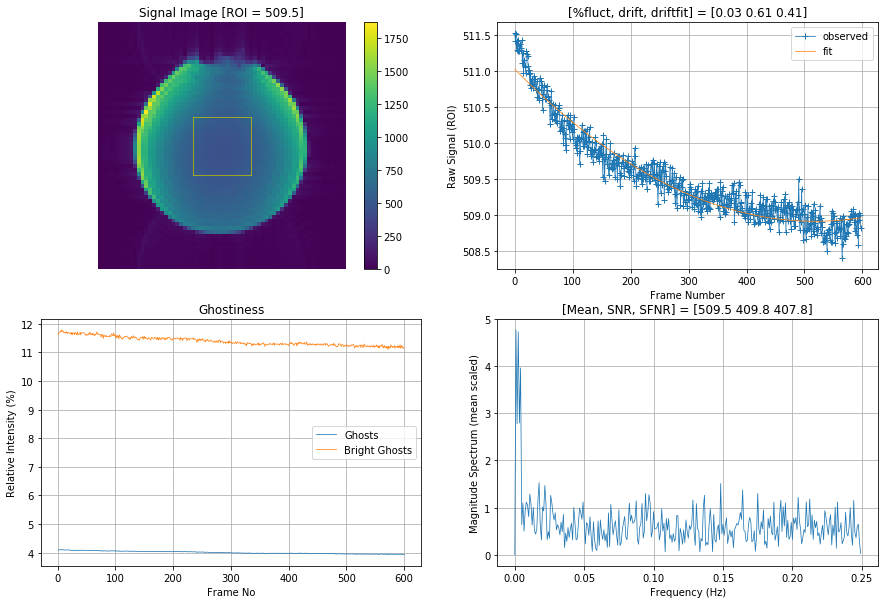

In [21]:
# Time course of gain fluctuations in an ROI
roisize = 15

time_course = fmriqa.roi_means_time_course(central_slice_time_series, roisize=roisize)
nt = len(time_course)
(a, b, c) = np.polyfit(range(nt), time_course, deg=2)
trend = np.polyval((a, b, c), range(nt))

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flat

# Average Image
im = axs[0].imshow(fmriqa.signal_image(central_slice_time_series), cmap='viridis')
axs[0].axis('off')
axs[0].set_title('Signal Image [ROI = %0.1f]' % fmriqa.signal_summary(central_slice_time_series, roisize=roisize))
fig.colorbar(im, ax=axs[0])

# Show the region of interest to be used
x1, x2, y1, y2 = int(nx/2-roisize/2), int(nx/2+roisize/2), int(ny/2-roisize/2), int(ny/2+roisize/2)
axs[0].axhline(y=y1, xmin=(x1+0.5)/nx,    xmax=(x2+0.5)/nx,    color='y')
axs[0].axvline(x=x1, ymin=(ny-y1-0.5)/ny, ymax=(ny-y2-0.5)/ny, color='y')
axs[0].axhline(y=y2, xmin=(x1+0.5)/nx,    xmax=(x2+0.5)/nx,    color='y')
axs[0].axvline(x=x2, ymin=(ny-y1-0.5)/ny, ymax=(ny-y2-0.5)/ny, color='y')

# Time course of gain fluctuations in an ROI
axs[1].plot(np.arange(nt), time_course, '+-', label='observed')
axs[1].plot(np.arange(nt), trend, '-', label='fit')
sd, fluct, drift_raw, drift_fit = fmriqa.fluctuation_and_drift(
                              central_slice_time_series, roisize=roisize)
summary_vals = (fluct, drift_raw, drift_fit)
axs[1].set_title('[%%fluct, drift, driftfit] = [%.2f %.2f %.2f]' % summary_vals)
axs[1].set_xlabel('Frame Number')
axs[1].set_ylabel('Raw Signal (ROI)')
axs[1].grid('on')
axs[1].legend()

# Average strength of ghosts and of the 'brightest' ghosts
pmeans, gmeans, bright_gmeans, snrs = fmriqa.ghostiness_trends(time_series)
axs[2].plot(range(1, len(gmeans)+1), 100*gmeans/pmeans, '-', label='Ghosts')
axs[2].plot(range(1, len(bright_gmeans)+1), 100*bright_gmeans/pmeans, '-', label='Bright Ghosts')

axs[2].set_title('Ghostiness')
axs[2].set_xlabel('Frame No')
axs[2].set_ylabel('Relative Intensity (%)')
axs[2].grid('on')
axs[2].legend()

# Magnitude spectrum of temporal fluctuations in an ROI
spectrum = fmriqa.magnitude_spectrum(central_slice_time_series, roisize=roisize)
nf = len(spectrum)
frequencies = np.linspace(0, (nf-1.0)/dt/nf/2.0, num=nf)
df = 1/dt

axs[3].plot(frequencies, spectrum, '-')
summary_vals = (fmriqa.signal_summary(central_slice_time_series, roisize=roisize),
                fmriqa.snr_summary(central_slice_time_series, roisize=roisize),
                fmriqa.sfnr_summary(central_slice_time_series, roisize=roisize))

axs[3].set_title('[Mean, SNR, SFNR] = [%.1f %.1f %.1f]' % summary_vals)
axs[3].set_xlabel('Frequency (Hz)')
axs[3].set_ylabel('Magnitude Spectrum (mean scaled)')
axs[3].grid('on');

The stability is similar to that from the other Skyra system we have measured as is the relatively high Nyquist ghost level, though this has increased slightly from previous measurements.

In [22]:
NewPage

## Proton Spectroscopy
We use the Siemens MRS metabolite phantom to assess the width and shape of the water line in an unlocalised FID and the acetate and lactate lines in SE and STEAM localised single voxel acquisitions.

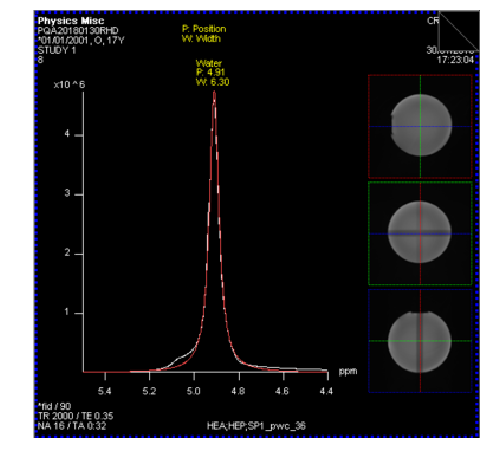

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(plt.imread('ScreenShots/water.png'))
plt.axis('off');

The unsupressed water line width is around 6Hz. This is indicative of a satisfactory shim over the large volume of the phantom. However, there is some evidence of asymmetry in the lineshape which may be related to shim or eddy current effects.

Acetate is a singlet intended to correspond to NAA in-vivo and lactate has a (methyl) doublet and a (methine) quartet. We have acquired SE localised single voxel spectra at three echo times. 

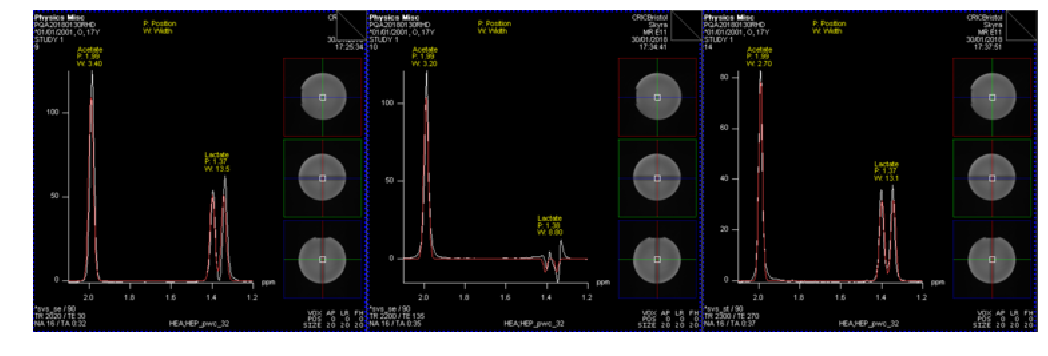

In [22]:
plt.figure(figsize=(18, 6))
plt.imshow(plt.imread('ScreenShots/spin_echo.png'))
plt.axis('off');

The acetate linewidth is just over 3 Hz and all the features of the lactate spectrum are present (the quartet is not displayed here). Furthermore, the line shape of the Acetate singlet is regular with no evidence of artefacts from eddy currents. The suppression of the lactate doublet at intermediate echo time is expected on 3T systems.

We have also acquired spectra using stimulated echo localisation.

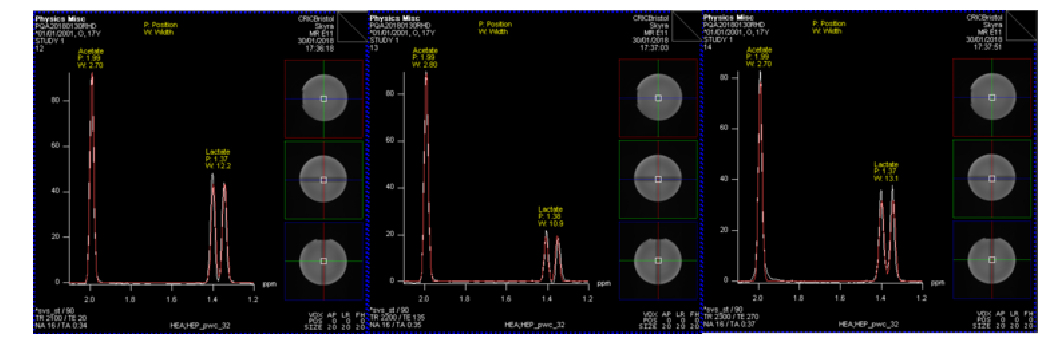

In [21]:
plt.figure(figsize=(18, 6))
plt.imshow(plt.imread('ScreenShots/steam.png'))
plt.axis('off');

As expected in this case, the lactate doublet is preserved at 135ms.

In [23]:
NewPage